<font size="+3">Time-series Generative Adversarial Network (TimeGAN): Experiment 8</font>  
from "Machine Learning for Algorithmic Trading" 2nd Ed. by Stefan Jansen

Adapted from the excellent paper by Jinsung Yoon, Daniel Jarrett, and Mihaela van der Schaar:  
[Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks),  
Neural Information Processing Systems (NeurIPS), 2019.

- Last updated Date: April 24th 2020
- [Original code](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/timegan/) author: Jinsung Yoon (jsyoon0823@gmail.com)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Repositories

/content/gdrive/MyDrive/Repositories


## Installs

These may or may not be necessary.

In [ ]:
!pip3 install --upgrade tables
!pip3 install keras-tcn --no-dependencies

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip3 install pandas_datareader --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.1 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


# Imports  & Settings

## Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import time
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (GRU, Dense, 
                                     RNN, GRUCell, Input, 
                                     Permute, Lambda)
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_style('white')

## GPU

In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


## Parameters

In [ ]:
results_path = Path('./TCN_TimeGAN_Repo')
if not results_path.exists():
    results_path.mkdir()

In [ ]:
os.chdir(results_path)

In [ ]:
from src.params_08 import ( experiment, 
                                        ## Data Parameters
                                        data_file,
                                        ts_names,
                                        start_date,
                                        end_date,

                                        ## Parameters
                                        n_seq, 
                                        seq_len,
                                        batch_size,
                                        train_steps,
                                        gamma,
                                        rho,

                                        ##  Network Parameters
                                        hidden_dim,
                                        latent_dim,
                                        n_layers_disc,
                                        n_layers_supv,

                                        ## Generic Loss Functions
                                        mse,
                                        bce,

                                        ## Optimizers
                                        autoencoder_optimizer,
                                        embedding_optimizer,
                                        discriminator_optimizer,
                                        generator_optimizer,
                                        supervisor_optimizer,

                                        ## Pooling Parameters
                                        pooler,
                                        latent_sample_rate )

In [ ]:
os.chdir('../')

# Experiment Path

In [ ]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [ ]:
sample_dir = log_dir / 'samples'
if not sample_dir.exists():
    sample_dir.mkdir(parents=True)

In [ ]:
evals_dir = log_dir / 'evals'
if not evals_dir.exists():
    evals_dir.mkdir(parents=True)

In [ ]:
data_dir = log_dir / 'data'
if not data_dir.exists():
    data_dir.mkdir(parents=True)

In [ ]:
events_dir = log_dir / 'events'
if not events_dir.exists():
    events_dir.mkdir(parents=True)

In [ ]:
hdf_store = log_dir / f'TimeSeriesGAN_{experiment:02}.h5'

# Prepare Data

## Get Data

In [ ]:
import pandas_datareader as pdr
import datetime as dt
ticker = ['BA', 'CAT', 'DIS', 'GE', 'IBM', 'KO']
start = dt.datetime(*start_date)
end = dt.datetime(*end_date)
data = pdr.get_data_yahoo(ticker, start, end).iloc[:,:n_seq]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4528 entries, 2000-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Adj Close, BA)   4528 non-null   float64
 1   (Adj Close, CAT)  4528 non-null   float64
 2   (Adj Close, DIS)  4528 non-null   float64
 3   (Adj Close, GE)   4528 non-null   float64
 4   (Adj Close, IBM)  4528 non-null   float64
 5   (Adj Close, KO)   4528 non-null   float64
dtypes: float64(6)
memory usage: 247.6 KB


In [ ]:
data.head()

Attributes  Adj Close                                                        
Symbols            BA        CAT        DIS          GE        IBM         KO
Date                                                                         
2000-01-03  25.940279  13.234139  23.115255  211.468399  64.820793  15.115060
2000-01-04  25.899939  13.064034  24.469284  203.009766  62.620495  15.131816
2000-01-05  27.513645  13.370221  25.484810  202.657242  64.820793  15.265878
2000-01-06  27.796047  14.050633  24.469284  205.366638  63.703148  15.282634
2000-01-07  28.602890  14.509923  24.082417  213.318817  63.423759  16.288073

In [ ]:
data.tail()

Attributes   Adj Close                                                  \
Symbols             BA         CAT         DIS          GE         IBM   
Date                                                                     
2017-12-22  281.228210  137.633423  105.682114  128.002625  116.088051   
2017-12-26  281.475952  138.243118  105.147240  128.370865  116.339249   
2017-12-27  281.723755  139.197510  104.680428  128.002594  116.567642   
2017-12-28  282.419464  139.992828  104.806862  127.855354  117.260376   
2017-12-29  281.047119  139.250565  104.554016  128.518143  116.788383   

Attributes             
Symbols            KO  
Date                   
2017-12-22  39.162327  
2017-12-26  39.351311  
2017-12-27  39.454384  
2017-12-28  39.274002  
2017-12-29  39.411438

In [ ]:
data.to_hdf(hdf_store, 'data/real')

## Plot Series

In [ ]:
tickers = ts_names

In [ ]:
df = pd.read_hdf(hdf_store, 'data/real')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4528 entries, 2000-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Adj Close, BA)   4528 non-null   float64
 1   (Adj Close, CAT)  4528 non-null   float64
 2   (Adj Close, DIS)  4528 non-null   float64
 3   (Adj Close, GE)   4528 non-null   float64
 4   (Adj Close, IBM)  4528 non-null   float64
 5   (Adj Close, KO)   4528 non-null   float64
dtypes: float64(6)
memory usage: 247.6 KB


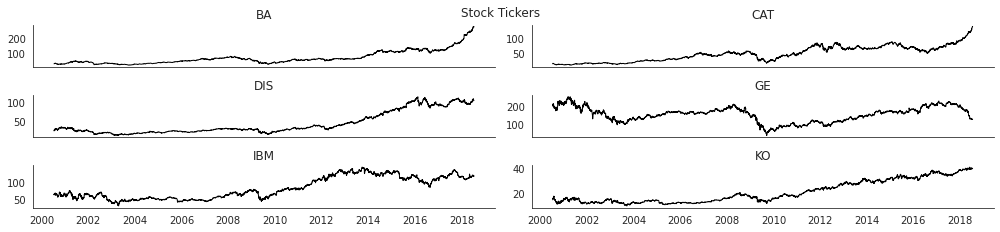

In [ ]:
axes = df.loc[start:end].plot(subplots=True,
                                        figsize=(14, 6),
                                        layout=(n_seq, 2),
                                        title=tickers,
                                        legend=False,
                                        rot=0,
                                        lw=1, 
                                        color='k')
for ax in axes.flatten():
    ax.set_xlabel('')

plt.suptitle('Stock Tickers')
plt.gcf().tight_layout()
sns.despine();

## Correlation

In [ ]:
df.corr()

Attributes         Adj Close                                                  
Symbols                   BA       CAT       DIS        GE       IBM        KO
Attributes Symbols                                                            
Adj Close  BA       1.000000  0.832957  0.904420  0.358726  0.656715  0.870546
           CAT      0.832957  1.000000  0.756789  0.055975  0.840561  0.858740
           DIS      0.904420  0.756789  1.000000  0.421744  0.748349  0.935167
           GE       0.358726  0.055975  0.421744  1.000000  0.059347  0.239620
           IBM      0.656715  0.840561  0.748349  0.059347  1.000000  0.886283
           KO       0.870546  0.858740  0.935167  0.239620  0.886283  1.000000

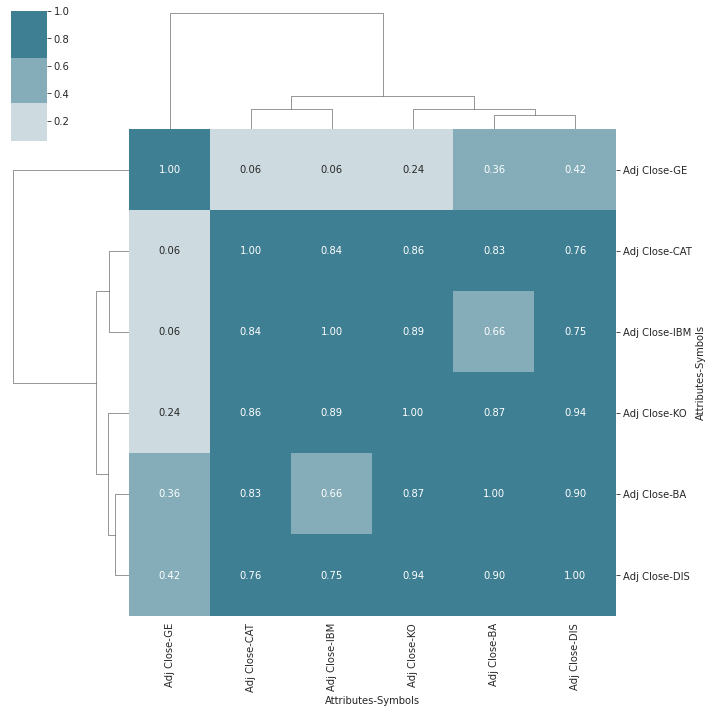

In [ ]:
sns.clustermap(df.corr(),
               annot=True,
               fmt='.2f',
               cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0);

## Normalize Data

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

## Create rolling window sequences

In [ ]:
data = []
for i in range(len(df)-seq_len): 
  data.append(scaled_data[i:i + seq_len])
n_windows = len(data)
print(n_windows)

4348


In [ ]:
[len(data), data[0].shape]

[4348, (180, 6)]

## Create tf.data.Dataset

In [ ]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

## Set up random series generator

In [ ]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

We use the Python generator to feed a `tf.data.Dataset` that continues to call the random number generator as long as necessary and produces the desired batch size.

In [ ]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

## Block generator (RNN)

In [ ]:
def make_rnn(input_shape, n_layers, hidden_units, output_units, name):
    return Sequential([Input(shape=input_shape)] +      
                      [GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRUvy_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

# TimeGAN Components

The design of the supervisor and discriminator follows the author's sample code. The embedder, recovery and generator are based on the Temporal Convolutional Network (TCN).

## Set up logger

In [ ]:
writer = tf.summary.create_file_writer(events_dir.as_posix())

## Generator (TCN), Discriminator and Supervisor (RNN) 

In [ ]:
from src.tcn_ae import TCN_AE

tcn_ae = TCN_AE(ts_len=seq_len, ts_dimension=n_seq, latent_sample_rate=latent_sample_rate, pooler=pooler)
tcn_generator = tcn_ae.build_encoder()

Model: "TCN_Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 180, 6)]          0         
                                                                 
 TCN_Encoder (Functional)    (None, 45, 8)             74908     
                                                                 
 TCN_Decoder (Functional)    (None, 180, 6)            75706     
                                                                 
Total params: 150,614
Trainable params: 150,614
Non-trainable params: 0
_________________________________________________________________
Model: "TCN_Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 180, 6)]          0         
                                                                 
 tcn-enc (TCN)          

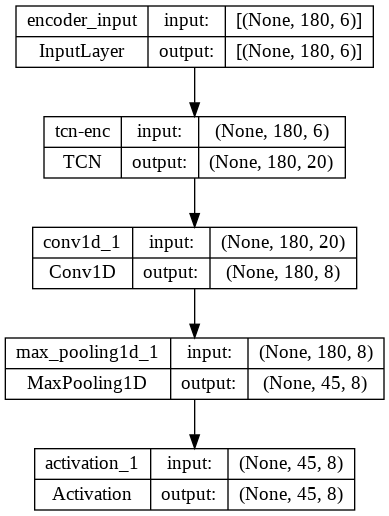

In [ ]:
plot_model(tcn_generator, show_shapes=True)

In [ ]:
supervisor = make_rnn(input_shape=[45, 8], 
                          n_layers=n_layers_supv, 
                          hidden_units=latent_dim, 
                          output_units=latent_dim, 
                          name='Supervisor')

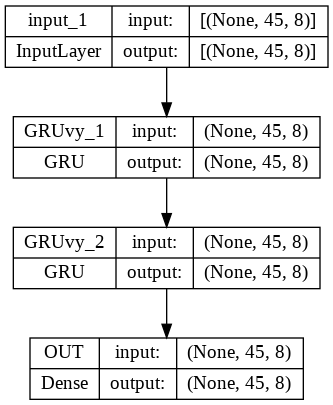

In [ ]:
plot_model(supervisor, show_shapes=True)

In [ ]:
discriminator = make_rnn(input_shape=[45, 8],
                         n_layers=n_layers_disc, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')

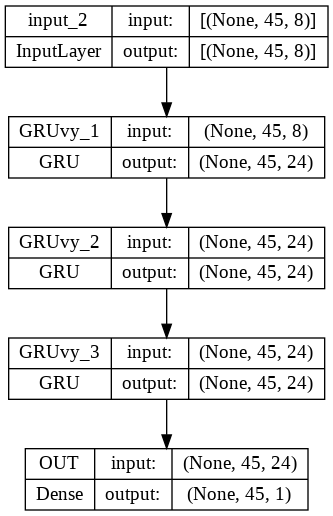

In [ ]:
plot_model(discriminator, show_shapes=True)

## Input place holders

In [ ]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

In [ ]:
tcn_generator(X).shape

TensorShape([None, 45, 8])

In [ ]:
discriminator(tcn_generator(X)).shape

TensorShape([None, 45, 1])

In [ ]:
supervisor(tcn_generator(X)).shape

TensorShape([None, 45, 8])

# TimeGAN Training

# Phase 1: Autoencoder Training

## Architecture TCN

In [ ]:
embedder = tcn_ae.build_encoder()
recovery = tcn_ae.build_decoder()

Model: "TCN_Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 180, 6)]          0         
                                                                 
 tcn-enc (TCN)               (None, 180, 20)           74740     
                                                                 
 conv1d_2 (Conv1D)           (None, 180, 8)            168       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 45, 8)            0         
 1D)                                                             
                                                                 
 activation_2 (Activation)   (None, 45, 8)             0         
                                                                 
Total params: 74,908
Trainable params: 74,908
Non-trainable params: 0
___________________________________________________

In [ ]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')
autoencoder.summary()                   

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 180, 6)]          0         
                                                                 
 TCN_Encoder (Functional)    (None, 45, 8)             74908     
                                                                 
 TCN_Decoder (Functional)    (None, 180, 6)            75706     
                                                                 
Total params: 150,614
Trainable params: 150,614
Non-trainable params: 0
_________________________________________________________________


## Autoencoder Training Step

In [ ]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)        
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)
        
    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Autoencoder Training Loop

In [ ]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 10000/10000 [05:02<00:00, 33.02it/s]


## Persist Autoencoder Model

In [ ]:
autoencoder.save(log_dir / 'autoencoder')

# Phase 2: Supervised training

In [ ]:
autoencoder = tf.keras.models.load_model(log_dir / 'autoencoder')

## Supervisor Train Step

In [ ]:
@tf.function
def train_supervisor(x):    
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])
    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

## Supervisor Training Loop

In [ ]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 10000/10000 [01:35<00:00, 104.35it/s]


## Persist Supervisor Model

In [ ]:
supervisor.save(log_dir / 'supervisor')

In [ ]:
supervisor = tf.keras.models.load_model(log_dir / 'supervisor')

# Joint Training

## Generator

### Adversarial Architecture - Supervised

In [ ]:
E_hat = tcn_generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [ ]:
E_hat.shape

TensorShape([None, 45, 8])

In [ ]:
H_hat.shape

TensorShape([None, 45, 8])

In [ ]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 180, 6)]          0         
                                                                 
 TCN_Encoder (Functional)    (None, 45, 8)             74908     
                                                                 
 Supervisor (Sequential)     (None, 45, 8)             936       
                                                                 
 Discriminator (Sequential)  (None, 45, 1)             9673      
                                                                 
Total params: 85,517
Trainable params: 85,517
Non-trainable params: 0
_________________________________________________________________


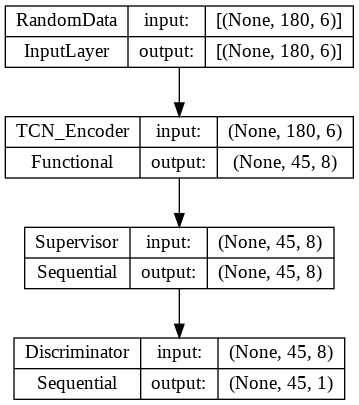

In [ ]:
plot_model(adversarial_supervised, show_shapes=True)

### Adversarial Architecture in Latent Space

In [ ]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [ ]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 180, 6)]          0         
                                                                 
 TCN_Encoder (Functional)    (None, 45, 8)             74908     
                                                                 
 Discriminator (Sequential)  (None, 45, 1)             9673      
                                                                 
Total params: 84,581
Trainable params: 84,581
Non-trainable params: 0
_________________________________________________________________


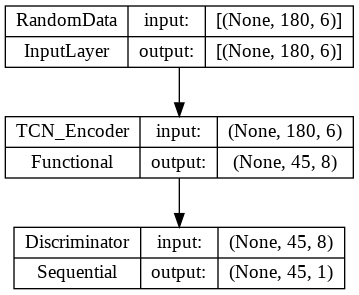

In [ ]:
plot_model(adversarial_emb, show_shapes=True)

## Synthesizer

In [ ]:
X_hat = recovery(H_hat)
synthesizer = Model(inputs=Z,
                       outputs=X_hat,
                       name='Synthesizer')

In [ ]:
synthesizer.summary()

Model: "Synthesizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 180, 6)]          0         
                                                                 
 TCN_Encoder (Functional)    (None, 45, 8)             74908     
                                                                 
 Supervisor (Sequential)     (None, 45, 8)             936       
                                                                 
 TCN_Decoder (Functional)    (None, 180, 6)            75706     
                                                                 
Total params: 151,550
Trainable params: 151,550
Non-trainable params: 0
_________________________________________________________________


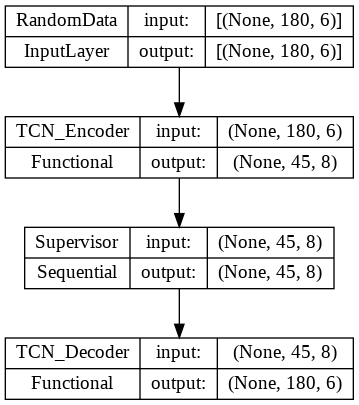

In [ ]:
plot_model(synthesizer, show_shapes=True)

### Moment Loss and Roughness Loss

In [ ]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

In [ ]:
def get_roughness_loss(x,y):
  #
  t = (x - y).numpy()
  ts_loss = np.sum(np.sum(np.diff(t, n=2, axis=0)**2, axis=0)/len(x), axis=0)
  return sum(ts_loss)

## Discriminator

### Architecture: Real Data

In [ ]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [ ]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 180, 6)]          0         
                                                                 
 TCN_Encoder (Functional)    (None, 45, 8)             74908     
                                                                 
 Discriminator (Sequential)  (None, 45, 1)             9673      
                                                                 
Total params: 84,581
Trainable params: 84,581
Non-trainable params: 0
_________________________________________________________________


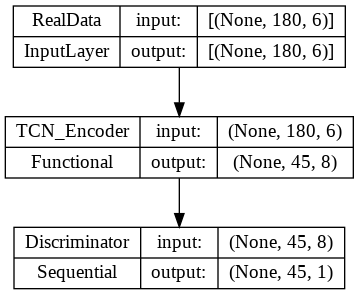

In [ ]:
plot_model(discriminator_model, show_shapes=True)

## Generator Train Step

In [ ]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthesizer(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)
        generator_roughness_loss = rho * get_roughness_loss(x, x_hat)
        
        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss +
                          generator_roughness_loss)
    
    var_list = tcn_generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss, generator_roughness_loss

## Embedding Train Step

In [ ]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Discriminator Train Step

In [ ]:
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [ ]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

## Joint Training Loop

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
min_loss = np.inf
patience = 4
brk_crit = 1e-4
wait = 0

In [ ]:
tf.config.run_functions_eagerly(True)

step_g_loss_u = step_g_loss_s = step_g_loss_v = step_g_loss_r = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):        
        Z_ = next(random_series)
        X_ = next(real_series_iter)
        while X_.shape != Z_.shape:
            X_ = next(real_series_iter)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v, step_g_loss_r = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)
        
    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 100 == 0: 
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.6f} | g_loss_v: {step_g_loss_v:6.4f} | g_loss_r: {step_g_loss_r:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')
        
        wait += 1
        if min_loss - step_g_loss_s >= brk_crit:
          min_loss =  step_g_loss_s
          wait = 0
        if wait >= patience:
          break
        
    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('G Loss R', step_g_loss_r, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)  
                               
synthesizer.save(log_dir / 'synthesizer')        

     0 | d_loss: 2.0406 | g_loss_u: 0.6794 | g_loss_s: 0.004890 | g_loss_v: 0.5242 | g_loss_r: 0.0000 | e_loss_t0: 0.0088
   100 | d_loss: 1.6618 | g_loss_u: 0.8536 | g_loss_s: 0.000016 | g_loss_v: 0.0946 | g_loss_r: 0.0000 | e_loss_t0: 0.0085
   200 | d_loss: 1.6549 | g_loss_u: 0.9777 | g_loss_s: 0.000006 | g_loss_v: 0.0995 | g_loss_r: 0.0000 | e_loss_t0: 0.0090
   300 | d_loss: 0.5055 | g_loss_u: 3.5651 | g_loss_s: 0.000003 | g_loss_v: 0.0541 | g_loss_r: 0.0000 | e_loss_t0: 0.0083
   400 | d_loss: 0.2996 | g_loss_u: 5.4008 | g_loss_s: 0.000003 | g_loss_v: 0.0837 | g_loss_r: 0.0000 | e_loss_t0: 0.0087
   500 | d_loss: 0.4556 | g_loss_u: 4.9407 | g_loss_s: 0.000002 | g_loss_v: 0.0626 | g_loss_r: 0.0000 | e_loss_t0: 0.0092


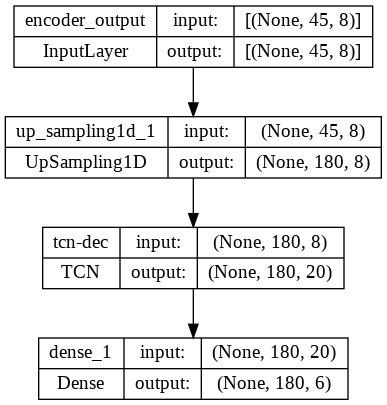

In [ ]:
plot_model(recovery, show_shapes=True)

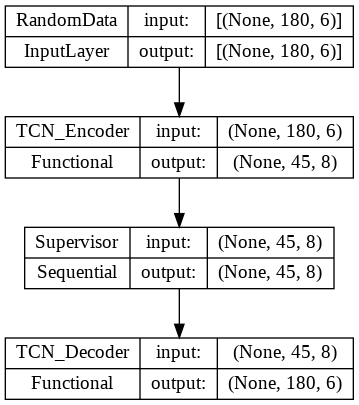

In [ ]:
plot_model(synthesizer, show_shapes=True)

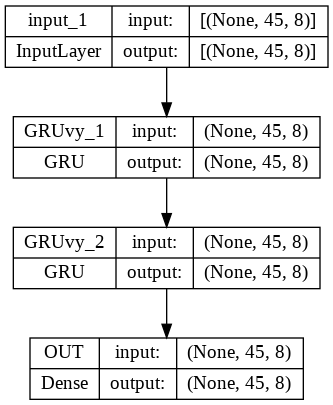

In [ ]:
plot_model(supervisor, show_shapes=True)

# Generate Synthetic Data

## Cold Start
Retrieves the data needed to generate synthetic data. Run ONLY if you haven't run the previous cells.

In [ ]:
# Run only if you need to cold start 
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Repositories

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Repositories


In [ ]:
%cd "g:/My Drive/Repositories"

g:\My Drive\Repositories


In [ ]:
# Imports
import os
import pandas as pd
import numpy as np
import time

from sklearn.preprocessing import MinMaxScaler
from tcn import TCN
from pathlib import Path
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (GRU, Dense, 
                                     RNN, GRUCell, Input, 
                                     Permute, Lambda)
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_style('white')


In [ ]:
# parameters
results_path = Path('./TCN_TimeGAN_Repo')
os.chdir(results_path)
from src.params_08 import ( experiment, 
                                        ## Data Parameters
                                        data_file,
                                        ts_names,
                                        start_date,
                                        end_date,

                                        ## Parameters
                                        n_seq, 
                                        seq_len,
                                        batch_size,
                                        train_steps,
                                        gamma,

                                        ##  Network Parameters
                                        hidden_dim,
                                        latent_dim,
                                        n_layers_disc,
                                        n_layers_supv,

                                        ## Generic Loss Functions
                                        mse,
                                        bce,

                                        ## Optimizers
                                        autoencoder_optimizer,
                                        embedding_optimizer,
                                        discriminator_optimizer,
                                        generator_optimizer,
                                        supervisor_optimizer,

                                        ## Pooling Parameters
                                        pooler,
                                        latent_sample_rate )
os.chdir('../')

In [ ]:
# Experiment Path
log_dir = results_path / f'experiment_{experiment:02}'
hdf_store = log_dir / f'TimeSeriesGAN_{experiment:02}.h5'

In [ ]:
# Get Data
df = pd.read_hdf(hdf_store, 'data/real')
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

# Create Rolling Windows
data = []
for i in range(len(df)-seq_len): 
  data.append(scaled_data[i:i + seq_len])
  
n_windows = len(data)  

c:\Users\arsin\anaconda3\envs\timeGAN\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\arsin\anaconda3\envs\timeGAN\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
synthesizer = tf.keras.models.load_model(log_dir / 'synthesizer')

In [ ]:
# Create TF Dataset
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

In [ ]:
# Set up random series generator
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

## Warm Start

In [85]:
real_data = np.stack(data)
real_data.shape

(4348, 180, 6)

In [86]:
pwr2 = np.floor(np.log2(len(real_data))).astype(int)
near_len = 2**pwr2
near_len

4096

In [87]:
generated_data = []
for i in range(near_len//batch_size):
    Z_ = next(random_series)
    d = synthesizer(Z_)
    generated_data.append(d)

In [88]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(4096, 180, 6)

In [89]:
np.save(log_dir / 'generated_data.npy', generated_data)

In [90]:
n_samples = 512
rng = np.random.default_rng()
idx_r = rng.choice(n_windows, n_samples)
idx_g = rng.choice(near_len, n_samples)
real_sample = real_data[idx_r,:,:]
gen_sample = generated_data[idx_g,:,:]

## Rescale

In [91]:
gen_sample = (scaler.inverse_transform(gen_sample
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
gen_sample.shape

(512, 180, 6)

In [92]:
real_sample = (scaler.inverse_transform(real_sample
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
real_sample.shape

(512, 180, 6)

## Persist Data

In [93]:
tickers = ts_names
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=tickers))

## Plot sample Series


Sample Plot: 6


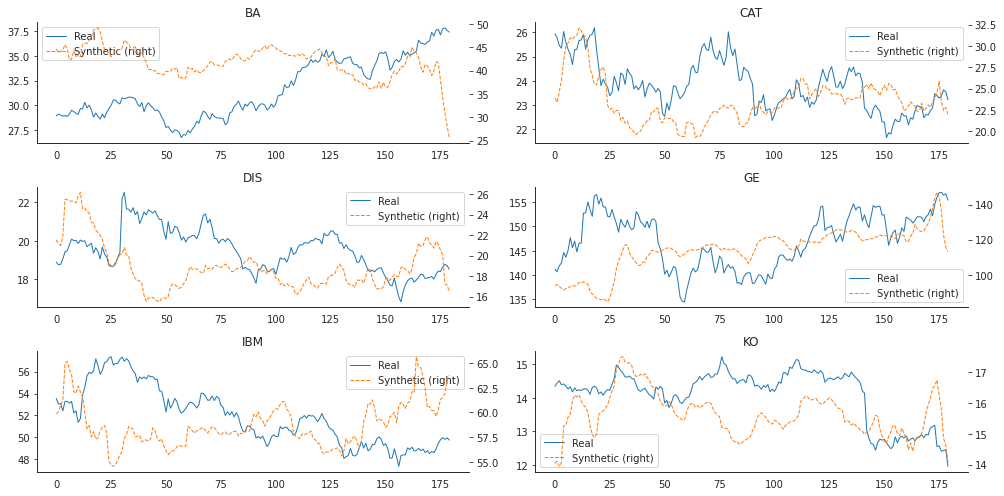


Sample Plot: 7


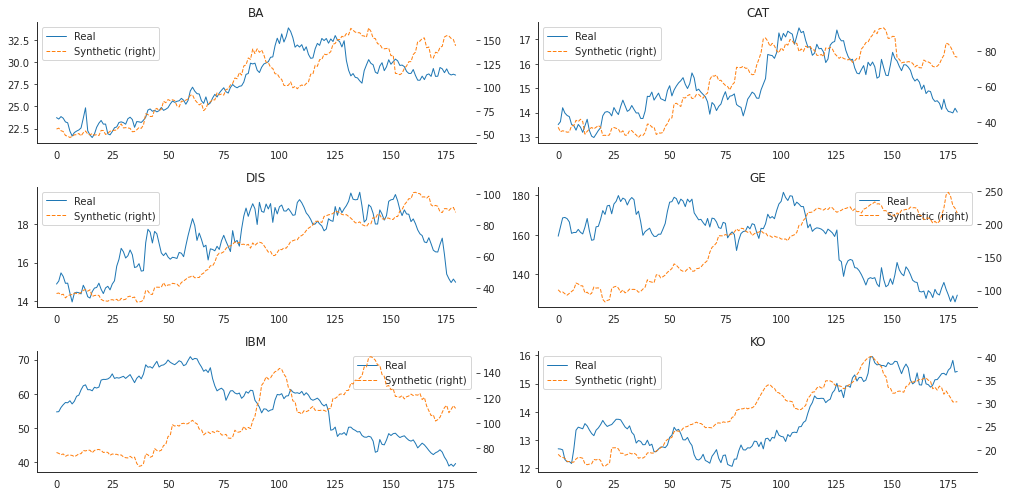


Sample Plot: 8


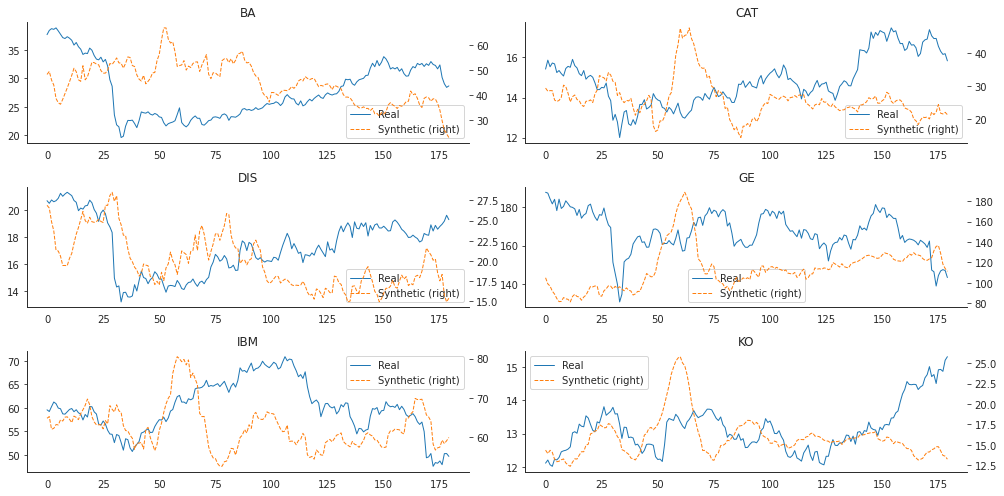


Sample Plot: 9


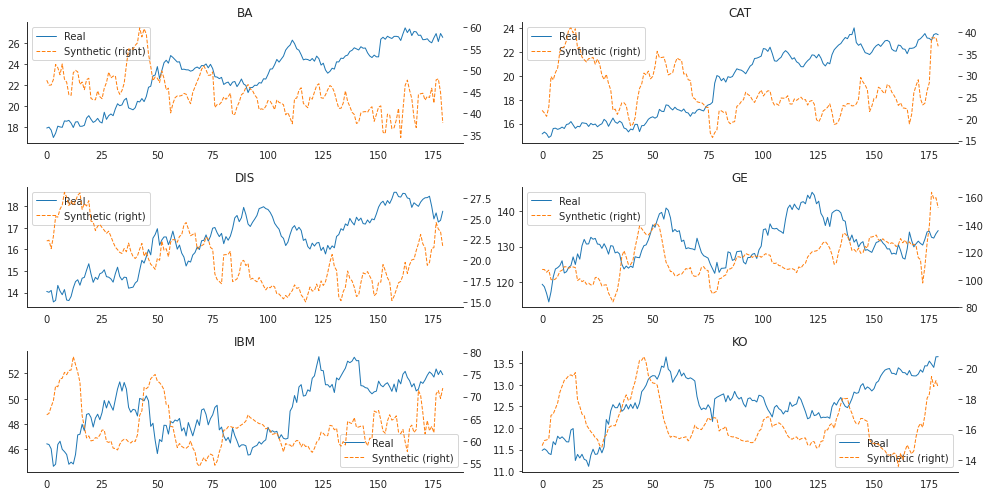

In [94]:
n_init = 5
n_plots = 4

for n in range(n_init, n_init + n_plots):
  print("\nSample Plot: %d" % (n + 1))
  fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
  axes = axes.flatten()
  
  idx = np.random.randint(len(real_sample))
  synthetic = gen_sample[idx]
  real = real_sample[idx]

  for j, ticker in enumerate(tickers):
      (pd.DataFrame({'Real': real[:, j],
                    'Synthetic': synthetic[:,j]})
      .plot(ax=axes[j],
            title=ticker,
            secondary_y='Synthetic', style=['-', '--'],
            lw=1))
  sns.despine()

  fig.tight_layout()
  plt.show()
  f_name = os.path.join(log_dir, "samples", "sample_" + str(n + 1 ) + ".png")
  fig.savefig(f_name)